In [1]:
# See requirements.txt to set up your dev environment.
import os
import cv2
import sys
import json
import scipy
import urllib
import datetime 
import urllib3
import rasterio
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
from osgeo import gdal
from planet import api
from planet.api import filters
from traitlets import link
import rasterio.tools.mask as rio_mask
from shapely.geometry import mapping, shape
from IPython.display import display, Image, HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from scipy import ndimage
urllib3.disable_warnings()
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

%matplotlib inline
# will pick up api_key via environment variable PL_API_KEY
# but can be specified using `api_key` named argument
api_keys = json.load(open("apikeys.json",'r'))
client = api.ClientV1(api_key=api_keys["PLANET_API_KEY"])

# Let's pull it all together to do something cool.
* Let's reuse a lot of our code to make a movie of our travel around Portland.
* We'll first select a bunch of recent scenes, activate, and download them.
* After that we'll create a mosaic, a path, and trace the path through the moasic. 
* We'll use the path to crop subregions, save them as images, and create a video.
* First step is to trace our AOI and a path through it.

In [2]:
# Basemap Mosaic (v1 API)
mosaicsSeries = 'global_quarterly_2017q1_mosaic'
# Planet tile server base URL (Planet Explorer Mosaics Tiles)
mosaicsTilesURL_base = 'https://tiles0.planet.com/experimental/mosaics/planet-tiles/' + mosaicsSeries + '/gmap/{z}/{x}/{y}.png'
# Planet tile server url
mosaicsTilesURL = mosaicsTilesURL_base + '?api_key=' + api_keys["PLANET_API_KEY"]
# Map Settings 
# Define colors
colors = {'blue': "#009da5"}
# Define initial map center lat/long
center = [45.5231, -122.6765]
# Define initial map zoom level
zoom = 11
# Set Map Tiles URL
planetMapTiles = TileLayer(url= mosaicsTilesURL)
# Create the map
m = Map(
    center=center, 
    zoom=zoom,
    default_tiles = planetMapTiles # Uncomment to use Planet.com basemap
)
# Define the draw tool type options
polygon = {'shapeOptions': {'color': colors['blue']}}
rectangle = {'shapeOptions': {'color': colors['blue']}} 

# Create the draw controls
# @see https://github.com/ellisonbg/ipyleaflet/blob/master/ipyleaflet/leaflet.py#L293
dc = DrawControl(
    polygon = polygon,
    rectangle = rectangle
)
# Initialize an action counter variable
actionCount = 0
AOIs = {}

# Register the draw controls handler
def handle_draw(self, action, geo_json):
    # Increment the action counter
    global actionCount
    actionCount += 1
    # Remove the `style` property from the GeoJSON
    geo_json['properties'] = {}
    # Convert geo_json output to a string and prettify (indent & replace ' with ")
    geojsonStr = json.dumps(geo_json, indent=2).replace("'", '"')
    AOIs[actionCount] = json.loads(geojsonStr)
    
# Attach the draw handler to the draw controls `on_draw` event
dc.on_draw(handle_draw)
m.add_control(dc)
m

# Query the API
* Now we'll save the geometry for our AOI and the path.
* We'll also filter and cleanup our data just like before.

In [3]:
areaAOI = AOIs[1]["geometry"]
pathAOI = AOIs[2]["geometry"]

aoi_file ="portland.geojson" 
with open(aoi_file,"w") as f:
    f.write(json.dumps(areaAOI))
# build a query using the AOI and
# a cloud_cover filter that excludes 'cloud free' scenes

old = datetime.datetime(year=2017,month=1,day=1)

query = filters.and_filter(
    filters.geom_filter(areaAOI),
    filters.range_filter('cloud_cover', gt=0),
    filters.date_range('acquired', gt=old)
)

# build a request for only PlanetScope imagery
request = filters.build_search_request(
    query, item_types=['PSScene3Band']
)

# if you don't have an API key configured, this will raise an exception
result = client.quick_search(request)
scenes = []
planet_map = {}
for item in result.items_iter(limit=500):
    planet_map[item['id']]=item
    props = item['properties']
    props["id"] = item['id']
    props["geometry"] = item["geometry"]
    props["thumbnail"] = item["_links"]["thumbnail"]
    scenes.append(props)
scenes = pd.DataFrame(data=scenes)
display(scenes)
print len(scenes)

acquired  anomalous_pixels  cloud_cover  columns  \
0    2017-04-23T18:05:25.715989Z              0.51         0.05     9237   
1    2017-04-19T18:06:45.464541Z              0.01         0.07     9104   
2    2017-04-19T18:06:44.407174Z              0.06         0.27     9098   
3    2017-04-19T18:13:13.697499Z              0.02         0.03     9311   
4    2017-04-19T18:13:17.985463Z              0.03         0.12     9314   
5    2017-04-19T18:13:15.841481Z              0.01         0.02     9315   
6    2017-04-19T18:05:22.830263Z              0.06         0.22     9198   
7    2017-04-19T18:13:16.913472Z              0.03         0.10     9312   
8     2017-04-19T18:13:14.76949Z              0.03         0.03     9315   
9    2017-04-19T18:05:20.715291Z              0.01         0.01     9198   
10   2017-04-19T18:05:19.657805Z              0.02         0.03     9195   
11   2017-04-19T18:05:23.887749Z              0.10         0.18     9196   
12   2017-04-19T18:05:21.772777Z              0.01         0.09     9193   
13   2017-04-18T18:06:53.053834Z              0.43         0.69     9056   
14     2017-04-18T18:06:51.9988Z              0.34         0.72     9051   
15   2017-04-15T18:05:05.023325Z              0.01         0.01     9194   
16   2017-04-15T18:05:06.090242Z              0.01         0.03     9195   
17   2017-04-15T18:05:03.956408Z              0.01         0.22     9196   
18   2017-04-15T18:05:07.157159Z              0.01         0.08     9196   
19   2017-04-15T18:05:02.889491Z              0.01         0.21     9192   
20    2017-04-15T18:13:55.98385Z              0.00         0.01     9030   
21   2017-04-15T18:13:53.846468Z              0.00         0.13     9157   
22   2017-04-15T18:13:52.777777Z              0.00         0.16     9171   
23   2017-04-15T18:13:54.915159Z              0.00         0.04     9222   
24    2017-04-13T18:04:50.09731Z              0.41         0.69     9063   
25   2017-04-13T18:04:52.206028Z              0.15         0.28     9055   
26   2017-04-13T18:04:53.260387Z              0.12         0.23     9057   
27   2017-04-13T18:04:51.151669Z              0.22         0.49     9058   
28   2017-04-13T18:04:54.314746Z              0.18         0.26     9053   
29   2017-04-13T18:06:01.212034Z              0.07         0.57     9006   
..                           ...               ...          ...      ...   
81   2017-02-18T18:11:02.480028Z              0.21         0.53     8976   
82   2017-02-18T18:11:01.398882Z              0.03         0.44     8986   
83   2017-02-18T18:11:00.317736Z              0.02         0.27     8988   
84    2017-02-18T18:10:59.23659Z              0.02         0.36     8992   
85   2017-02-10T21:06:34.690971Z              0.00         0.18     5766   
86   2017-02-11T18:11:20.085436Z              0.01         0.01     8928   
87    2017-01-29T18:10:26.24497Z              0.00         0.18     9145   
88   2017-01-29T18:10:28.441058Z              0.00         0.02     9145   
89   2017-01-29T18:10:30.637146Z              0.00         0.13     9146   
90   2017-01-29T18:10:27.343014Z              0.00         0.07     9146   
91   2017-01-29T18:10:29.539102Z              0.00         0.06     9145   
92   2017-01-28T18:11:24.665644Z              0.01         0.19     9212   
93   2017-01-28T18:11:22.542294Z              0.01         0.24     9181   
94   2017-01-28T18:11:21.480619Z              0.01         0.33     9179   
95   2017-01-28T18:11:23.603969Z              0.01         0.05     9173   
96   2017-01-20T18:09:44.366053Z              0.01         0.46     9207   
97   2017-01-20T18:09:42.176013Z              0.01         0.34     9211   
98   2017-01-20T18:09:45.461073Z              0.03         0.34     9210   
99   2017-01-20T18:09:43.271033Z              0.01         0.36     9200   
100  2017-01-20T18:09:41.080993Z              0.02         0.40     9211   
101  2017-01-15T18:10:36.289403Z              0.01         0.01     9264

111


# Just like before we clean up our data and distill it down to just the scenes we want.

In [4]:
# now let's clean up the datetime stuff
# make a shapely shape from our aoi
portland = shape(areaAOI)
footprints = []
overlaps = []
# go through the geometry from our api call, convert to a shape and calculate overlap area.
# also save the shape for safe keeping
for footprint in scenes["geometry"].tolist():
    s = shape(footprint)
    footprints.append(s)
    overlap = 100.0*(portland.intersection(s).area / portland.area)
    overlaps.append(overlap)
# take our lists and add them back to our dataframe
scenes['overlap'] = pd.Series(overlaps, index=scenes.index)
scenes['footprint'] = pd.Series(footprints, index=scenes.index)
# now make sure pandas knows about our date/time columns.
scenes["acquired"] = pd.to_datetime(scenes["acquired"])
scenes["published"] = pd.to_datetime(scenes["published"])
scenes["updated"] = pd.to_datetime(scenes["updated"])
scenes.head()

# Now let's get it down to just good, recent, clear scenes
clear = scenes['cloud_cover']<0.4
good = scenes['quality_category']=="standard"
recent = scenes["acquired"] > datetime.date(year=2017,month=1,day=1)
partial_coverage = scenes["overlap"] > 10
good_scenes = scenes[(good&clear&recent&partial_coverage)]
print good_scenes




                      acquired  anomalous_pixels  cloud_cover  columns  \
4   2017-04-19 18:13:17.985463              0.03         0.12     9314   
5   2017-04-19 18:13:15.841481              0.01         0.02     9315   
6   2017-04-19 18:05:22.830263              0.06         0.22     9198   
7   2017-04-19 18:13:16.913472              0.03         0.10     9312   
8   2017-04-19 18:13:14.769490              0.03         0.03     9315   
9   2017-04-19 18:05:20.715291              0.01         0.01     9198   
10  2017-04-19 18:05:19.657805              0.02         0.03     9195   
12  2017-04-19 18:05:21.772777              0.01         0.09     9193   
15  2017-04-15 18:05:05.023325              0.01         0.01     9194   
16  2017-04-15 18:05:06.090242              0.01         0.03     9195   
17  2017-04-15 18:05:03.956408              0.01         0.22     9196   
19  2017-04-15 18:05:02.889491              0.01         0.21     9192   
21  2017-04-15 18:13:53.846468        

# To make sure we are good we'll visually inspect the scenes in our slippy map.

In [5]:
# first create a list of colors
colors = ["#ff0000","#00ff00","#0000ff","#ffff00","#ff00ff","#00ffff","#ff0000","#00ff00","#0000ff","#ffff00","#ff00ff","#00ffff"]
# grab our scenes from the geometry/footprint geojson
# Chane this number as needed
footprints = good_scenes[0:10]["geometry"].tolist()
# for each footprint/color combo
for footprint,color in zip(footprints,colors):
    # create the leaflet object
    feat = {'geometry':footprint,"properties":{
            'style':{'color': color,'fillColor': color,'fillOpacity': 0.2,'weight': 1}},
            'type':u"Feature"}
    # convert to geojson
    gjson = GeoJSON(data=feat)
    # add it our map
    m.add_layer(gjson)
# now we will draw our original AOI on top 
feat = {'geometry':areaAOI,"properties":{
            'style':{'color': "#FFFFFF",'fillColor': "#FFFFFF",'fillOpacity': 0.5,'weight': 1}},
            'type':u"Feature"}
gjson = GeoJSON(data=feat)
m.add_layer(gjson)   
m 

# This is from the previous notebook. We are just activating and downloading scenes.

In [6]:
def get_products(client, scene_id, asset_type='PSScene3Band'):    
    """
    Ask the client to return the available products for a 
    given scene and asset type. Returns a list of product 
    strings
    """
    out = client.get_assets_by_id(asset_type,scene_id)
    temp = out.get()
    return temp.keys()

def activate_product(client, scene_id, asset_type="PSScene3Band",product="analytic"):
    """
    Activate a product given a scene, an asset type, and a product.
    
    On success return the return value of the API call and an activation object
    """
    temp = client.get_assets_by_id(asset_type,scene_id)  
    products = temp.get()
    if( product in products.keys() ):
        return client.activate(products[product]),products[product]
    else:
        return None 

def download_and_save(client,product):
    """
    Given a client and a product activation object download the asset. 
    This will save the tiff file in the local directory and return its 
    file name. 
    """
    out = client.download(product)
    fp = out.get_body()
    fp.write()
    return fp.name

def scenes_are_active(scene_list):
    """
    Check if all of the resources in a given list of
    scene activation objects is read for downloading.
    """
    return True
    retVal = True
    for scene in scene_list:
        if scene["status"] != "active":
            print "{} is not ready.".format(scene)
            return False
    return True
def load_image4(filename):
    """Return a 4D (r, g, b, nir) numpy array with the data in the specified TIFF filename."""
    path = os.path.abspath(os.path.join('./', filename))
    if os.path.exists(path):
        with rasterio.open(path) as src:
            b, g, r, nir = src.read()
            return np.dstack([r, g, b, nir])
        
def load_image3(filename):
    """Return a 3D (r, g, b) numpy array with the data in the specified TIFF filename."""
    path = os.path.abspath(os.path.join('./', filename))
    if os.path.exists(path):
        with rasterio.open(path) as src:
            b,g,r,mask = src.read()
            return np.dstack([b, g, r])
        
def get_mask(filename):
    """Return a 1D mask numpy array with the data in the specified TIFF filename."""
    path = os.path.abspath(os.path.join('./', filename))
    if os.path.exists(path):
        with rasterio.open(path) as src:
            b,g,r,mask = src.read()
            return np.dstack([mask])

def rgbir_to_rgb(img_4band):
    """Convert an RGBIR image to RGB"""
    return img_4band[:,:,:3]

# Perform the actual activation ... go get coffee

In [7]:
to_get = good_scenes["id"][0:10].tolist()
activated = []
# for each scene to get
for scene in to_get:
    # get the product 
    product_types = get_products(client,scene)
    for p in product_types:
        # if there is a visual product
        if p == "visual": # p == "basic_analytic_dn"
            print "Activating {0} for scene {1}".format(p,scene)
            # activate the product
            _,product = activate_product(client,scene,product=p)
            activated.append(product)

Activating visual for scene 20170419_181317_0e0d
Activating visual for scene 20170419_181315_0e0d
Activating visual for scene 20170419_180522_1009
Activating visual for scene 20170419_181316_0e0d
Activating visual for scene 20170419_181314_0e0d
Activating visual for scene 20170419_180520_1009
Activating visual for scene 20170419_180519_1009
Activating visual for scene 20170419_180521_1009
Activating visual for scene 20170415_180505_1024
Activating visual for scene 20170415_180506_1024


# Downloand the scenes

In [8]:
tiff_files = []
asset_type = "_3B_Visual"
# check if our scenes have been activated
if scenes_are_active(activated):
    for to_download,name in zip(activated,to_get):
        # create the product name
        name = name + asset_type + ".tif"
        # if the product exists locally
        if( os.path.isfile(name) ):
            # do nothing 
            print "We have scene {0} already, skipping...".format(name)
            tiff_files.append(name)
        elif to_download["status"] == "active":
            # otherwise download the product
            print "Downloading {0}....".format(name)
            fname = download_and_save(client,to_download)
            tiff_files.append(fname)
            print "Download done."
        else:
            print "Could not download, still activating"
else:
    print "Scenes aren't ready yet"

print tiff_files 

We have scene 20170419_181317_0e0d_3B_Visual.tif already, skipping...
We have scene 20170419_181315_0e0d_3B_Visual.tif already, skipping...
We have scene 20170419_180522_1009_3B_Visual.tif already, skipping...
We have scene 20170419_181316_0e0d_3B_Visual.tif already, skipping...
We have scene 20170419_181314_0e0d_3B_Visual.tif already, skipping...
We have scene 20170419_180520_1009_3B_Visual.tif already, skipping...
We have scene 20170419_180519_1009_3B_Visual.tif already, skipping...
We have scene 20170419_180521_1009_3B_Visual.tif already, skipping...
We have scene 20170415_180505_1024_3B_Visual.tif already, skipping...
We have scene 20170415_180506_1024_3B_Visual.tif already, skipping...
[u'20170419_181317_0e0d_3B_Visual.tif', u'20170419_181315_0e0d_3B_Visual.tif', u'20170419_180522_1009_3B_Visual.tif', u'20170419_181316_0e0d_3B_Visual.tif', u'20170419_181314_0e0d_3B_Visual.tif', u'20170419_180520_1009_3B_Visual.tif', u'20170419_180519_1009_3B_Visual.tif', u'20170419_180521_1009_3B_

# Now, just like before, we will mosaic those scenes.

In [11]:
commands = ["gdalwarp", # t
           "-t_srs","EPSG:3857",
           "-cutline",aoi_file,
           "-crop_to_cutline",
           "-tap",
            "-tr", "3", "3"
           "-overwrite"]
output_mosaic = "portland_mosaic.tif"
for tiff in tiff_files:
    commands.append(tiff)
commands.append(output_mosaic)
print " ".join(commands)
subprocess.call(commands)

gdalwarp -t_srs EPSG:3857 -cutline portland.geojson -crop_to_cutline -tap -tr 3 3-overwrite 20170419_181317_0e0d_3B_Visual.tif 20170419_181315_0e0d_3B_Visual.tif 20170419_180522_1009_3B_Visual.tif 20170419_181316_0e0d_3B_Visual.tif 20170419_181314_0e0d_3B_Visual.tif 20170419_180520_1009_3B_Visual.tif 20170419_180519_1009_3B_Visual.tif 20170419_180521_1009_3B_Visual.tif 20170415_180505_1024_3B_Visual.tif 20170415_180506_1024_3B_Visual.tif portland_mosaic.tif


0

# Let's take a look at what we got

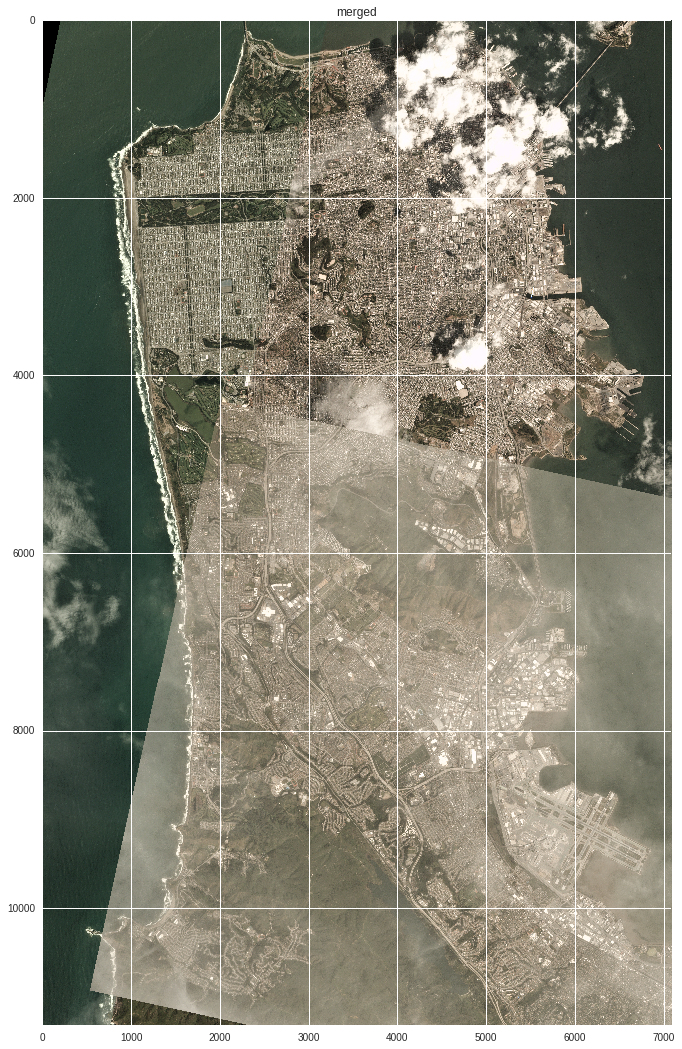

In [12]:
merged = load_image3(output_mosaic)
plt.figure(0,figsize=(18,18))
plt.imshow(merged)
plt.title("merged")

In [13]:
def crop_to_area(scene,x_c,y_c,w,h):
    tlx = x_c-(w/2)
    tly = y_c-(h/2)
    brx = x_c+(w/2)
    bry = y_c+(h/2)
    return scene[tly:bry,tlx:brx,:]

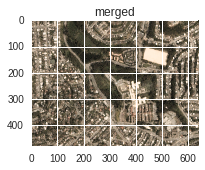

In [14]:
plt.figure(0,figsize=(3,4))
plt.imshow(crop_to_area(merged,3000,3000,640,480))
plt.title("merged")

In [15]:
from osgeo import gdal,ogr,osr
#https://gis.stackexchange.com/questions/57834/how-to-get-raster-corner-coordinates-using-python-gdal-bindings
def GetExtent(gt,cols,rows):
    ext=[]
    xarr=[0,cols]
    yarr=[0,rows]

    for px in xarr:
        for py in yarr:
            x=gt[0]+(px*gt[1])+(py*gt[2])
            y=gt[3]+(px*gt[4])+(py*gt[5])
            ext.append([x,y])
            print x,y
        yarr.reverse()
    return ext

def ReprojectCoords(coords,src_srs,tgt_srs):
    trans_coords=[]
    transform = osr.CoordinateTransformation( src_srs, tgt_srs)
    for x,y in coords:
        x,y,z = transform.TransformPoint(x,y)
        trans_coords.append([x,y])
    return trans_coords

raster=output_mosaic
ds=gdal.Open(raster)

gt=ds.GetGeoTransform()
cols = ds.RasterXSize
rows = ds.RasterYSize
ext=GetExtent(gt,cols,rows)

src_srs=osr.SpatialReference()
src_srs.ImportFromWkt(ds.GetProjection())
#tgt_srs=osr.SpatialReference()
#tgt_srs.ImportFromEPSG(4326)
tgt_srs = src_srs.CloneGeogCS()

extents = ReprojectCoords(ext,src_srs,tgt_srs)
print extents

-13641030.0 4553202.0
-13641030.0 4519254.0
-13619778.0 4519254.0
-13619778.0 4553202.0
[[-122.53945740132913, 37.814131501676556], [-122.53945740132913, 37.57281907126879], [-122.34854743714803, 37.57281907126879], [-122.34854743714803, 37.814131501676556]]


In [16]:
def poor_mans_lat_lon_2_pix(lon,lat,w,h,extents):
    lats = [e[1] for e in extents]
    lons = [e[0] for e in extents]
    lat_max = np.max(lats)
    lat_min = np.min(lats)    
    lon_max = np.max(lons)
    lon_min = np.min(lons)    
    lat_diff = lat-lat_min
    lon_diff = lon-lon_min
    lat_r = float(h)/(lat_max-lat_min)
    lon_r = float(w)/(lon_max-lon_min)    
    return int(lat_r*lat_diff),int(lon_r*lon_diff)




[(10295, 1172), (10193, 5656), (7291, 6523), (6120, 5096), (4132, 5758), (1888, 6115), (2398, 5300), (3622, 3924), (4183, 2140), (5406, 1478), (8004, 1019), (7801, 3720), (8819, 5045), (9277, 2905), (9124, 1223)]


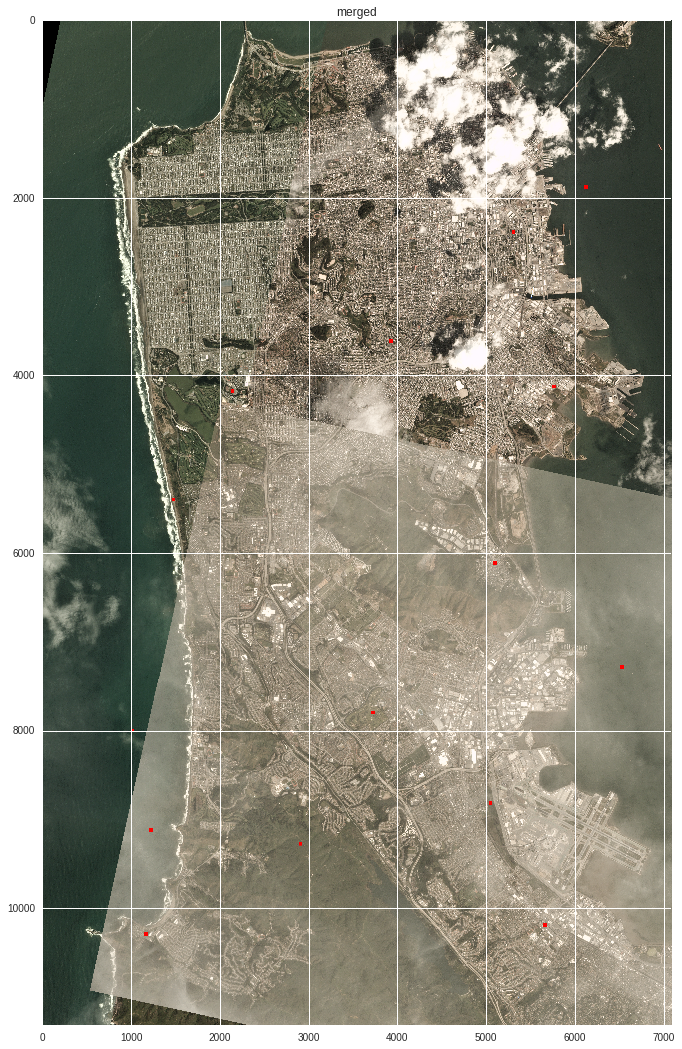

In [17]:
h,w,c = merged.shape
waypoints = [poor_mans_lat_lon_2_pix(point[0],point[1],w,h,extents) for point in pathAOI["coordinates"]]
print waypoints
def draw_point(x,y,img):
    t = 20
    img[y-t:y+t,x-t:x+t,:] = [255,0,0]
merged = load_image3(output_mosaic)
[draw_point(pt[1],pt[0],merged) for pt in waypoints]
plt.figure(0,figsize=(18,18))
plt.imshow(merged)
plt.title("merged")

In [27]:
def interpolate_waypoints(waypoints,velocity=10.0):
    retVal = []
    last_pt = waypoints[0]
    for next_pt in waypoints[1:]:
        distance = np.sqrt((last_pt[0]-next_pt[0])**2+(last_pt[1]-next_pt[1])**2)
        steps = np.ceil(distance/velocity)
        xs = np.array(np.linspace(last_pt[0],next_pt[0],steps),dtype='int64')
        ys = np.array(np.linspace(last_pt[1],next_pt[1],steps),dtype='int64')
        retVal += zip(xs,ys)
        last_pt = next_pt
    return retVal
def build_scenes(src,waypoints,window=[640,480],path="./movie/"):
    count = 0 
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    w2 = window[0]/2
    h2 = window[1]/2
    h,w,d = src.shape
    for pt in waypoints:
        temp = crop_to_area(src,pt[1],h-pt[0],window[0],window[1])
        if temp.shape[0]*temp.shape[1]== 0:
            print "derp"
            continue
        temp = cv2.resize(temp, (int(window[0]*0.75), int(window[1]*.75))) 
        fname = os.path.abspath(path+"img{num:06d}.png".format(num=count))
        cv2.imwrite(fname,temp)
        count += 1

(11316, 7084, 3)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.


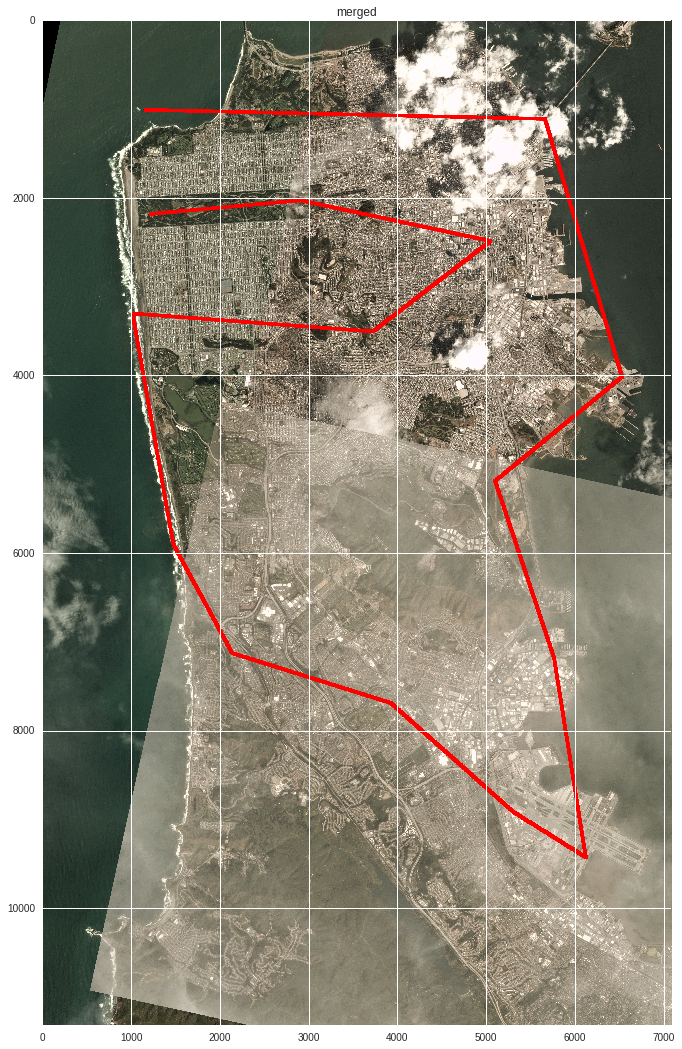

In [28]:
print merged.shape
merged = load_image3(output_mosaic)
interp = interpolate_waypoints(waypoints)
[draw_point(pt[1],h-pt[0],merged) for pt in interp]
plt.figure(0,figsize=(18,18))
plt.imshow(merged)
plt.title("merged")




In [ ]:
merged = load_image3(output_mosaic)
build_scenes(merged,interp)

In [ ]:
framerate = 30
output = "out.mpg"
command = ["avconv","-f", "framerate", str(framerate), "-f", "image2", "-i", "./movie/img%06d.png", "-b", "65536k", output]
subprocess.call(command)


In [ ]:
# this works but it isn't quite right
# Need to map lat lon to pixel
import rasterio
import numpy as np
from affine import Affine
from pyproj import Proj, transform
# Read raster
with rasterio.open(output_mosaic) as r:
    T0 = r.affine  # upper-left pixel corner affine transform
    print r.crs
    p1 = Proj(r.crs)
    A = r.read_band(1)  # pixel values

# All rows and columns
cols, rows = np.meshgrid(np.arange(A.shape[1]), np.arange(A.shape[0]))

# Get affine transform for pixel centres
T1 = T0 * Affine.translation(0.5, 0.5)
# Function to convert pixel row/column index (from 0) to easting/northing at centre
rc2en = lambda r, c: (c, r) * T1

# All eastings and northings (there is probably a faster way to do this)
eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(rows, cols)

# Project all longitudes, latitudes
p2 = Proj(proj='latlong',datum='WGS84')
longs, lats = transform(p1, p2, eastings, northings)
longs[0]